In [42]:
# ------------------------------------------------------------
# Step 1 · Imports and Paths
# ------------------------------------------------------------
import pandas as pd
import geopandas as gpd
from pathlib import Path
from shapely.geometry import Polygon, MultiPolygon, GeometryCollection
import matplotlib.pyplot as plt

In [43]:
# File paths
base_path = Path("/Users/rosstaylor/Downloads/Research Project/Code Folder/Research Project - Geospatial Health Demand/data/processed")
csv_fp = base_path / "projections/2024/all_icbs_2024.csv"
gpkg_fp = base_path / "lsoa_south_west_enriched.gpkg"

In [44]:
# ------------------------------------------------------------
# Step 2 · Load Files
# ------------------------------------------------------------
df_csv = pd.read_csv(csv_fp)
gdf_gpkg = gpd.read_file(gpkg_fp)

print(f"[CSV] Rows: {df_csv.shape[0]}, Columns: {df_csv.shape[1]}")
print(f"[GPKG] Rows: {gdf_gpkg.shape[0]}, Columns: {gdf_gpkg.shape[1]}")
print(f"CRS of GPKG: {gdf_gpkg.crs}")

[CSV] Rows: 3475, Columns: 22
[GPKG] Rows: 3472, Columns: 16
CRS of GPKG: EPSG:27700


In [45]:
# ------------------------------------------------------------
# Step 3 · Fix Invalid Geometry (e.g. GEOMETRYCOLLECTION)
# ------------------------------------------------------------
def extract_valid_geom(g):
    if isinstance(g, (Polygon, MultiPolygon)):
        return g
    elif isinstance(g, GeometryCollection):
        polys = [geom for geom in g.geoms if isinstance(geom, (Polygon, MultiPolygon))]
        return polys[0] if polys else None
    else:
        return None

gdf_gpkg["geometry"] = gdf_gpkg["geometry"].apply(extract_valid_geom)
gdf_gpkg = gdf_gpkg[gdf_gpkg["geometry"].notnull()]
print("Geometry cleaned. Remaining valid geometries:", len(gdf_gpkg))


Geometry cleaned. Remaining valid geometries: 3451


In [46]:
# ------------------------------------------------------------
# Step 4 · Merge CSV and GPKG
# ------------------------------------------------------------
# Drop geometry temporarily for merge
df_meta = gdf_gpkg.drop(columns="geometry")
df_merged = df_csv.merge(df_meta, on="lsoa21cd", how="inner")

# Reattach geometry using index alignment
geometry_series = gdf_gpkg.set_index("lsoa21cd").loc[df_merged["lsoa21cd"], "geometry"].values
gdf_final = gpd.GeoDataFrame(df_merged.copy(), geometry=geometry_series, crs=gdf_gpkg.crs)

print("Final GeoDataFrame shape:", gdf_final.shape)
print("CRS confirmed:", gdf_final.crs)

Final GeoDataFrame shape: (3454, 37)
CRS confirmed: EPSG:27700


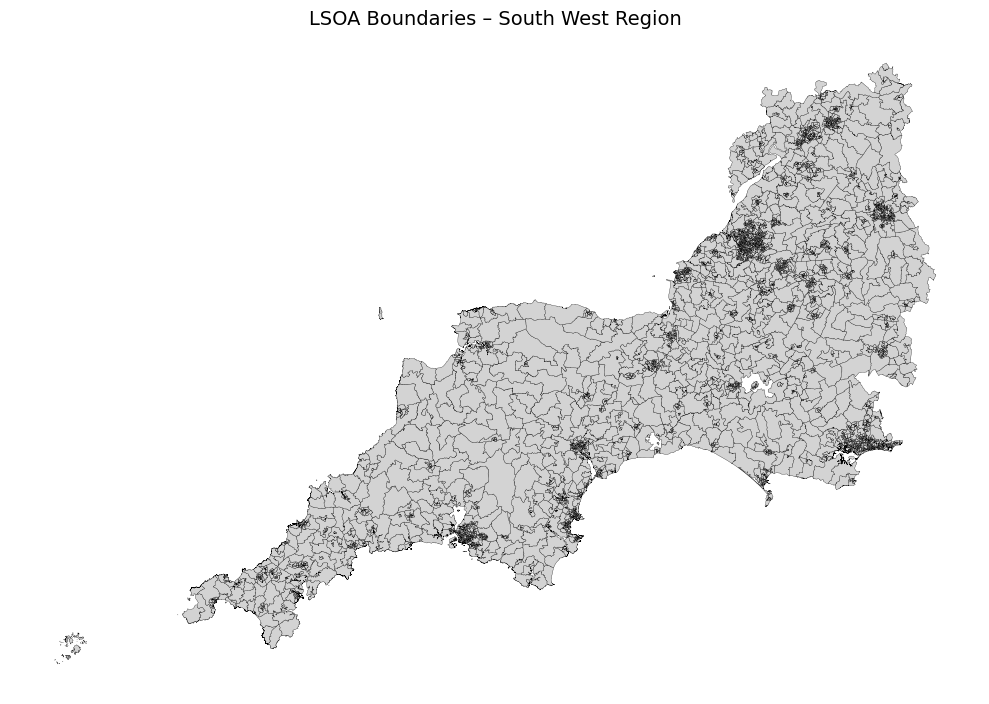

In [47]:
# ------------------------------------------------------------
# Step 5 · Visual Check – Plain LSOA Plot
# ------------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 12))
gdf_final.plot(ax=ax, edgecolor="black", facecolor="lightgrey", linewidth=0.2)
ax.set_title("LSOA Boundaries – South West Region", fontsize=14)
ax.axis("off")
plt.tight_layout()
plt.show()

In [50]:
# ------------------------------------------------------------
# Step 6 · Reorder and Clean Columns
# ------------------------------------------------------------

# Backup geometry
geometry_col = gdf_final.geometry.copy()

# Drop known unneeded columns if present
cols_to_drop = [
    "lsoa21nm_x", "lsoa21nm_y", "shape__are", "shape__len", "globalid"
]
gdf_final.drop(columns=[col for col in cols_to_drop if col in gdf_final.columns], inplace=True)

# Desired column order
desired_order = [
    "ICB23NM", "ladnm", "ladcd", "msoa21nm", "msoa21cd", "lsoa21nmw", "lsoa21cd",
    "total_population", "age_0_4", "age_5_9", "age_10_14", "age_15_19", "age_20_24",
    "age_25_29", "age_30_34", "age_35_39", "age_40_44", "age_45_49", "age_50_54",
    "age_55_59", "age_60_64", "age_65_69", "age_70_74", "age_75_79", "age_80_84", "age_85_plus",
    "lat", "long", "bng_e", "bng_n"
]

# Keep only those that exist
present_order = [col for col in desired_order if col in gdf_final.columns]
remaining_cols = [col for col in gdf_final.columns if col not in present_order and col != "geometry"]

# Reassemble
gdf_final = gpd.GeoDataFrame(
    gdf_final[present_order + remaining_cols].copy(),
    geometry=geometry_col,
    crs=gdf_final.crs
)

# ------------------------------------------------------------
# Step 7 · Confirm Final Output
# ------------------------------------------------------------
print("\nFinal GeoDataFrame Ready")
print(f"Shape: {gdf_final.shape}")
print(f"Columns: {list(gdf_final.columns)}")
print(f"CRS: {gdf_final.crs}")
print(gdf_final.head(2))



Final GeoDataFrame Ready
Shape: (3454, 32)
Columns: ['ICB23NM', 'ladnm', 'ladcd', 'msoa21nm', 'msoa21cd', 'lsoa21nmw', 'lsoa21cd', 'total_population', 'age_0_4', 'age_5_9', 'age_10_14', 'age_15_19', 'age_20_24', 'age_25_29', 'age_30_34', 'age_35_39', 'age_40_44', 'age_45_49', 'age_50_54', 'age_55_59', 'age_60_64', 'age_65_69', 'age_70_74', 'age_75_79', 'age_80_84', 'age_85_plus', 'lat', 'long', 'bng_e', 'bng_n', 'lsoa21nm', 'geometry']
CRS: EPSG:27700
                            ICB23NM   ladnm      ladcd    msoa21nm   msoa21cd  \
0  NHS Dorset Integrated Care Board  Dorset  E06000059  Dorset 042  E02004268   
1  NHS Dorset Integrated Care Board  Dorset  E06000059  Dorset 042  E02004268   

  lsoa21nmw   lsoa21cd  total_population  age_0_4  age_5_9  ...  age_70_74  \
0      None  E01020484           1444.99    43.76    70.21  ...     113.97   
1      None  E01020481           1347.30    39.69    32.56  ...     161.80   

   age_75_79  age_80_84  age_85_plus       lat     long   bng_e 

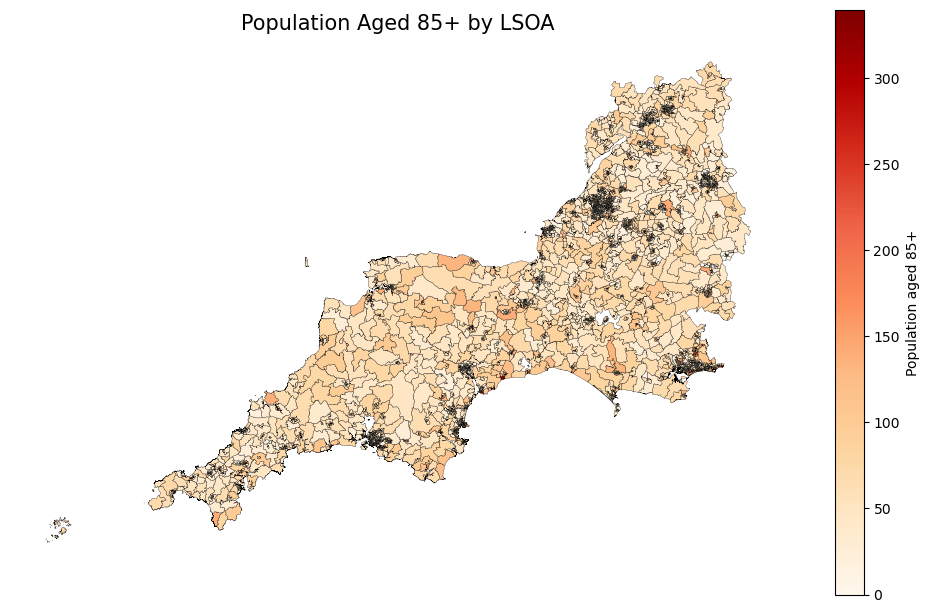

In [53]:
# ------------------------------------------------------------
# Step 8 · Visualise age_85_plus by LSOA
# ------------------------------------------------------------

fig, ax = plt.subplots(figsize=(10, 12))

# Plot with colour based on age_85_plus
gdf_final.plot(
    column="age_85_plus",
    cmap="OrRd",
    linewidth=0.2,
    edgecolor="black",
    legend=True,
    legend_kwds={"label": "Population aged 85+", "shrink": 0.5},
    ax=ax
)

ax.set_title("Population Aged 85+ by LSOA", fontsize=15)
ax.axis("off")
plt.tight_layout()
plt.show()


In [55]:
# ------------------------------------------------------------
# Step 9 · Save Final GeoDataFrame to GPKG (Master Version)
# ------------------------------------------------------------
# Define new output path
output_fp = base_path.parent / "master" / "LSOA_5-year_segment_master.gpkg"
output_fp.parent.mkdir(parents=True, exist_ok=True)  # Create directory if needed

# Write to GPKG
gdf_final.to_file(output_fp, driver="GPKG")

print(f"\nMaster GeoPackage saved to:\n{output_fp}")



Master GeoPackage saved to:
/Users/rosstaylor/Downloads/Research Project/Code Folder/Research Project - Geospatial Health Demand/data/master/LSOA_5-year_segment_master.gpkg
